## Convolutions

In [12]:
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

from n_framework import *

In [45]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor
from urllib.request import urlretrieve

from torch.utils.data import DataLoader
from typing import Mapping
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

In [14]:
mpl.rcParams['image.cmap'] = 'gray'

In [15]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [16]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])


In [17]:
x_imgs = x_train.view(-1,28,28)
xv_imgs = x_valid.view(-1,28,28)

In [18]:
mpl.rcParams['figure.dpi'] = 30

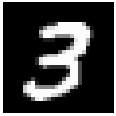

In [22]:
im3 = x_imgs[7]
show_image(im3);

In [23]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [1, 1, 1]]).float()

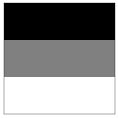

In [25]:
show_image(top_edge, noframe=False);

To apply the filter or Kernel

In [26]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [27]:
(im3[3:6,14:17]* top_edge).sum()

tensor(2.9727)

In [28]:
(im3[7:10,14:17] * top_edge).sum()

tensor(-2.9570)

In [33]:
def apply_kernel(row,col, kernel): return (im3[row-1:row+2,col-1:col+2] * kernel).sum()

In [34]:
apply_kernel(4,15,top_edge)

tensor(2.9727)

In [35]:
[[(i,j) for j in range(5)]for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

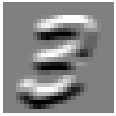

In [46]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng]for i in rng])
show_image(top_edge3);

In [47]:
left_edge = tensor([[-1, 1, 0],
                    [-1, 1, 0],
                    [-1, 1, 0]]).float()

<AxesSubplot:>

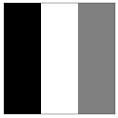

In [48]:
show_image(left_edge, noframe=False)

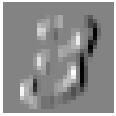

In [50]:
top_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng]for i in rng])
show_image(top_edge3);

## Convolutions in Pytorch

>speeding up the process

In [51]:
inp = im3[None,None,:,:].float()
inp_unf = F.unfold(inp, (3,3))[0]
inp_unf.shape

torch.Size([9, 676])

In [52]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

In [53]:
out_unf = w@inp_unf
out_unf.shape

torch.Size([676])

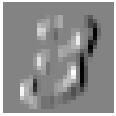

In [55]:
out = out_unf.view(26,26)
show_image(out);

In [56]:
%timeit -n 1 tensor([[apply_kernel(i,j,left_edge)for j in rng]for i in rng])

5.94 ms ± 2.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26,26)

63.2 µs ± 24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
%timeit -n 100 F.conv2d(inp,left_edge[None,None])

The slowest run took 6.02 times longer than the fastest. This could mean that an intermediate result is being cached.
24.5 µs ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

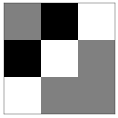

In [63]:
show_image(diag1_edge, noframe=False);

In [64]:
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

<AxesSubplot:>

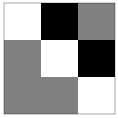

In [65]:
show_image(diag2_edge, noframe=False)

In [66]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

In [68]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge,diag2_edge])[:,None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [69]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

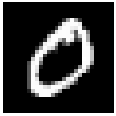

In [71]:
img0 = xb[1,0]
show_image(img0);

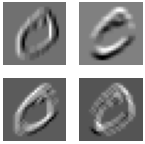

In [72]:
show_images([batch_features[1,i] for i in range(4)])

### Strides and Padding

 we normall use odd numbered Kernels
> if we use odd number kernel and one pixel padding we end up with the same size you start with, of the convolution

If we add a kernel of size ks by ks (with ks an odd number), the necessary padding on each side to keep the same shape is ks//2.

We could move over two pixels after each kernel application. This is known as a `stride-2 convolution` - they reduce our input dimentinality by a factor of 2 

### Creating a CNN

In [114]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50
n,m,nh

(50000, 784, 50)

In [115]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [124]:
m*nh + nh*10

39700

In [117]:
broken_cnn = nn.Sequential(
        nn.Conv2d(1,30, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(30,10, kernel_size=3, padding=1)
)

In [118]:
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

In [119]:
#|export
def conv(ni,nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni,nf, kernel_size = ks, stride=stride, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [120]:
simple_cnn = nn.Sequential(
    conv(1,4),   #14,14
    conv(4,8),   #7,7
    conv(8,16),  #4,4
    conv(16,16), #2,2
    conv(16,10, act=False), #1,1
    nn.Flatten(),)

In [121]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [122]:
x_imgs = x_train.view(-1, 1, 28, 28)
xv_imgs = x_valid.view(-1, 1, 28,28)
train_ds,valid_ds = Dataset(x_imgs,y_train), Dataset(xv_imgs, y_valid)

In [123]:
#| export
def_devices = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_devices):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))


In [93]:
bs = 256
lr =  0.4
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn = collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr =lr)

In [104]:
%time loss,acc = fit(5, simple_cnn.to(def_devices), F.cross_entropy, opt, train_dl, valid_dl)

0 0.08360874891281128 0.981199999332428
1 0.09065423185825348 0.9785999994277954
2 0.0933945307135582 0.980599999332428
3 0.0843539894580841 0.982199999332428
4 0.0978857141494751 0.9800999994277955
CPU times: user 5.19 s, sys: 540 ms, total: 5.73 s
Wall time: 6.67 s


In [105]:
opt = optim.SGD(simple_cnn.parameters(), lr = lr/4)
%time loss,acc = fit(5, simple_cnn.to(def_devices), F.cross_entropy, opt, train_dl, valid_dl)

0 0.08087177187204361 0.9837999995231629
1 0.08273399626016617 0.9847999995231629
2 0.08729387176036835 0.9837999996185303
3 0.09036697976589203 0.9831999995231628
4 0.09181184833049774 0.982699999332428
CPU times: user 5.19 s, sys: 663 ms, total: 5.85 s
Wall time: 6.73 s


The number of parameters of the models

In [125]:
m*nh + nh*10

39700

In [134]:
 tensor([np.product(o.shape) for o in model.parameters()]).sum()

tensor(39760)

In [135]:
 tensor([np.product(o.shape) for o in simple_cnn.parameters()]).sum()

tensor(5274)

In [137]:
 tensor([o.numel() for o in simple_cnn.parameters()]).sum()

tensor(5274)

In [138]:
simple_cnn

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)